In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

In [2]:
# Read file
hfp_dataset = pd.read_csv('../data/heart.csv')
hfp_dataset.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
hfp_dataset.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [4]:
# Split predictors and target value
X = hfp_dataset.copy()
y = X.pop('HeartDisease')

In [5]:
# Columns to normalize:
num_cols = []
for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        num_cols.append(col)

num_cols

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

In [6]:
# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], uniques = X[colname].factorize()
    print(f'{colname} = {uniques}')

discrete_features = X.dtypes == int
discrete_features

Sex = Index(['M', 'F'], dtype='object')
ChestPainType = Index(['ATA', 'NAP', 'ASY', 'TA'], dtype='object')
RestingECG = Index(['Normal', 'ST', 'LVH'], dtype='object')
ExerciseAngina = Index(['N', 'Y'], dtype='object')
ST_Slope = Index(['Up', 'Flat', 'Down'], dtype='object')


Age               False
Sex               False
ChestPainType     False
RestingBP         False
Cholesterol       False
FastingBS         False
RestingECG        False
MaxHR             False
ExerciseAngina    False
Oldpeak           False
ST_Slope          False
dtype: bool

In [7]:
X

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,0,0,140,289,0,0,172,0,0.0,0
1,49,1,1,160,180,0,0,156,0,1.0,1
2,37,0,0,130,283,0,1,98,0,0.0,0
3,48,1,2,138,214,0,0,108,1,1.5,1
4,54,0,1,150,195,0,0,122,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
913,45,0,3,110,264,0,0,132,0,1.2,1
914,68,0,2,144,193,1,0,141,0,3.4,1
915,57,0,2,130,131,0,0,115,1,1.2,1
916,57,1,0,130,236,0,2,174,0,0.0,1


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


# Standardize the features
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.optimizers import RMSprop, Adam


model = None
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Make predictions
predictions = model.predict(X_test)
binary_predictions = (predictions > 0.5).astype(int)

Epoch 1/30
19/19 [==============================] - 2s 23ms/step - loss: 0.7072 - accuracy: 0.6508 - val_loss: 0.6405 - val_accuracy: 0.7959
Epoch 2/30
19/19 [==============================] - 0s 6ms/step - loss: 0.5087 - accuracy: 0.7785 - val_loss: 0.6031 - val_accuracy: 0.8163
Epoch 3/30
19/19 [==============================] - 0s 7ms/step - loss: 0.4498 - accuracy: 0.8058 - val_loss: 0.5790 - val_accuracy: 0.8367
Epoch 4/30
19/19 [==============================] - 0s 8ms/step - loss: 0.4435 - accuracy: 0.8092 - val_loss: 0.5587 - val_accuracy: 0.8367
Epoch 5/30
19/19 [==============================] - 0s 7ms/step - loss: 0.4407 - accuracy: 0.8109 - val_loss: 0.5233 - val_accuracy: 0.8435
Epoch 6/30
19/19 [==============================] - 0s 8ms/step - loss: 0.4013 - accuracy: 0.8177 - val_loss: 0.4936 - val_accuracy: 0.8503
Epoch 7/30
19/19 [==============================] - 0s 7ms/step - loss: 0.4200 - accuracy: 0.8211 - val_loss: 0.4711 - val_accuracy: 0.8435
Epoch 8/30
19/19 [=

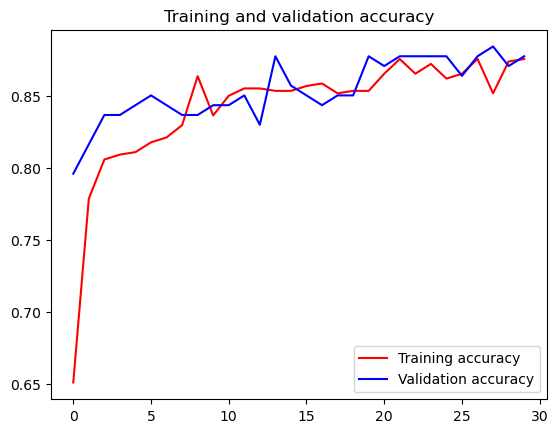

In [10]:
# Plot the training accuracy and validation accuracy with respect to epochs.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()